# Installation & Setup

Install some python packages

In [ ]:
%pip install us
%pip install matplotlib
%pip install seaborn
%pip install numpy
%pip install pandas

Import those packages

In [2]:
# Inline Chart Parameters
%matplotlib inline

from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 9)

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

# Python Imports
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import us
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Display all columns on tables
pd.set_option('display.max_columns', None)

In [24]:
# Download some data
pd.read_csv("https://raw.githubusercontent.com/dmil/columbia-transparency-series/master/raw-polls.csv")\
  .to_csv('raw-polls.csv', index=False)

# Download some data
pd.read_csv("https://raw.githubusercontent.com/dmil/columbia-transparency-series/master/pollster-ratings.csv")\
  .to_csv('pollster-ratings.csv', index=False)

# Thinking About An Upcoming Election

Can we trust the polls? And if so...how much?

In [3]:
# Load some data into variables
polls = pd.read_csv('raw-polls.csv')

# Reverses some values so that Democratic is on the left (-) and Republican is on the right (+)
polls['margin_poll'] = -polls['margin_poll']
polls['margin_actual'] = -polls['margin_actual']
polls['bias'] = -polls['bias']

In [4]:
# Define a function for plotting
def dotplot(df, x, y, result=None, figsize=(16,4), title='', 
            subtitle="<--- Democratic                                                                                       Republican --->"):
    """
    plot margin_poll (grey), average of margin_poll (white), and
    margin_actual (blue/red)
    """
    data = df.sort_values(by=y)    
    fig, ax = plt.subplots(figsize=figsize)
    
    xmax = max(50, df[x].max(), df[result].max() + 5 if result else 0)
    xmin = min(-50, df[x].min(), df[result].min() - 5 if result else 0)
    ax.set(xlim=(xmin, xmax))

    sns.stripplot(data=data,
                       x=x, y=y, orient='h', size=15,
                       jitter=False, alpha=.35, color='grey', ax=ax)        

    if result:
        sns.stripplot(data=data,
                           x=result, y=y, orient='h', size=15,
                           hue=data['margin_actual'].apply(lambda x: 'D' if x < 0 else 'R'),
                           palette={'D':'blue', 'R': 'red'},
                           jitter=False, alpha=0.75, ax=ax)

    data = (data.pivot_table(index=y, values=x, aggfunc='mean')
                .sort_values(by=y)
                .reset_index())

    sns.stripplot(data=data,
                  x=x, y=y, orient='h', size=15,
                  color='white', linewidth=1, jitter=False, alpha=1, ax=ax)    
        
    plt.axvline(x=0, color='black', linewidth=0.8)
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
        
    plt.suptitle(title, fontsize='x-large', fontweight='bold')
    plt.title(subtitle, fontsize='large', fontweight='book', alpha=0.75, pad=0.0)


## Filtering Practice
Before we start, let's get some practice filtering dataframes

In [5]:
# Get all National presidential polls
# filtered_polls = polls.query("type_detail=='Pres-G' and location=='US'")

# Get all National presidential polls for 2016
# filtered_polls = polls.query("type_detail=='Pres-G' and location=='US' and year==2016")

# Get all state-level presidential polls for 2016
# filtered_polls = polls.query("type_detail=='Pres-G' and location!='US' and year==2016")

# DISPLAY 3 RANDOM POLLS
# filtered_polls.sample(3)

Now you try it!

In [6]:
# Get New York's Gubernatorial polls
# my_filtered_polls = 

# Get all 2016 Senate polls conducted by YouGov
# my_filtered_polls = 

# DISPLAY 3 RANDOM POLLS
# my_filtered_polls.sample(3)

## Part1: So how are the polls doing? 

Lets look at the Nationwide popular vote. First, an exploratory visualization.

In [7]:
# A quick look at the polls dataframe
polls_to_analyze = polls.query("type_detail=='Pres-G' and location=='US'")
polls_to_analyze.head(2)

,pollno,race,year,location,type_simple,type_detail,pollster,pollster_rating_id,polldate,samplesize,cand1_name,cand1_pct,cand2_name,cand2_pct,cand3_pct,margin_poll,electiondate,cand1_actual,cand2_actual,margin_actual,error,bias,rightcall,comment,partisan
468,5380467,2000_Pres-G_US,2000,US,Pres-G,Pres-G,Georgetown University (Battleground),114,10/17/2000,1000.0,Democrat,40.0,Republican,44.0,4.0,4.0,11/7/2000,48.38,47.87,-0.51,4.51,4.51,0.0,NaN,NaN
477,5380476,2000_Pres-G_US,2000,US,Pres-G,Pres-G,NBC News/Wall Street Journal,221,10/18/2000,750.0,Democrat,43.0,Republican,45.0,3.0,2.0,11/7/2000,48.38,47.87,-0.51,2.51,2.51,0.0,NaN,NaN


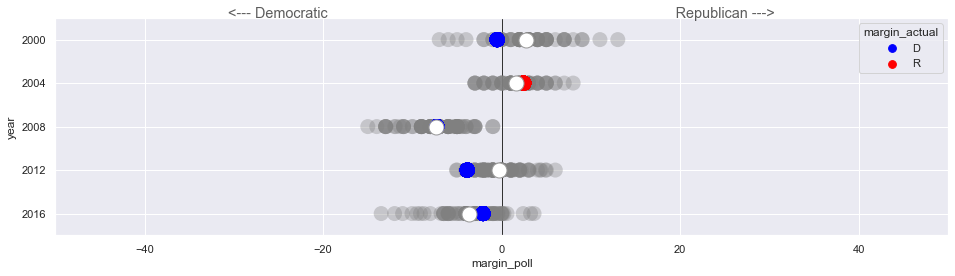

In [8]:
# plots margin_poll (grey), average of margin_poll (white), and margin_actual (blue/red)
dotplot(
    polls_to_analyze, 
    y='year', x='margin_poll', result='margin_actual', 
    title='')

Have the polls been getting increasingly biased? 

Now that we've glanced at the data, lets calculate the average error.

In [9]:
polls_to_analyze[['year', 'bias', 'error']]\
    .groupby('year').mean()

,bias,error
year,,
2000,3.274062,4.021562
2004,-0.855000,2.158333
2008,-0.082857,2.302857
2012,3.513837,3.578256
2016,-1.618472,2.799583


## But, we don't have one Presidential election ... 
**we have 50 separate ones....**

...and the nationwide polls can only tell us so much about who might win the election. So what about state polling? Has it been getting better or worse over the years? Can we still rely on it this coming election cycle? 

Lets start by digging into 2016 state polls.


In [10]:
# A quick look at the polls dataframe
presidential_state_level_polls = polls.query("type_detail=='Pres-G' and location!='US'")
presidential_state_level_polls.head(2)

,pollno,race,year,location,type_simple,type_detail,pollster,pollster_rating_id,polldate,samplesize,cand1_name,cand1_pct,cand2_name,cand2_pct,cand3_pct,margin_poll,electiondate,cand1_actual,cand2_actual,margin_actual,error,bias,rightcall,comment,partisan
463,5380462,2000_Pres-G_FL,2000,FL,Pres-G,Pres-G,McLaughlin & Associates,203,10/17/2000,600.0,Democrat,43.0,Republican,44.0,3.0,1.0,11/7/2000,48.84,48.85,0.01,0.99,0.99,1.0,NaN,R
464,5380463,2000_Pres-G_IL,2000,IL,Pres-G,Pres-G,KRC/Communications Research,160,10/17/2000,600.0,Democrat,45.0,Republican,43.0,4.0,-2.0,11/7/2000,54.60,42.58,-12.02,10.02,10.02,1.0,NaN,NaN


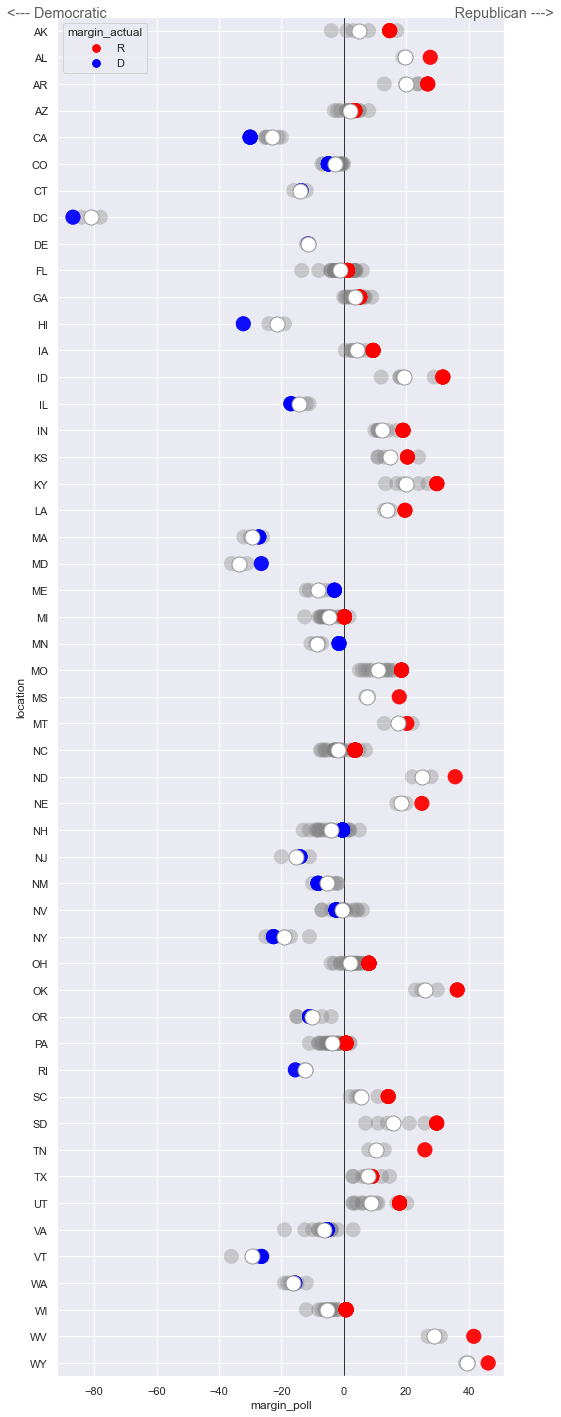

In [11]:
dotplot(presidential_state_level_polls.query("year==2016"), 
           x='margin_poll', y='location', result='margin_actual', 
           title = '',
           figsize=(8,25))

In [12]:
presidential_state_level_polls[['year', 'location', 'pollster', 'bias', 'error']]\
    .groupby('year').mean()

,bias,error
year,,
2000,1.966633,4.636599
2004,-0.989412,3.333669
2008,-0.089742,3.638798
2012,2.328907,3.632267
2016,-3.535924,5.249544


We can visualize just the bias across all the states by plotting bias instead of margin_poll

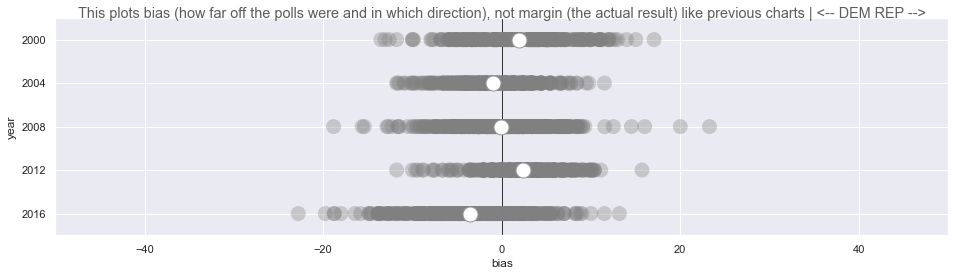

In [13]:
dotplot(presidential_state_level_polls,
    # x='margin_poll', y='year', result='margin_actual', # changing the chart from this to bias
    x='bias', y='year', 
    title='',
    subtitle='This plots bias (how far off the polls were and in which direction), not margin (the actual result) like previous charts | <-- DEM REP -->',
    figsize=(16,4))

### Try it yourself! 
- Tell me about Hawaii.

- Look at a state with a big miss or very accurate polling in 2016
    - Filter down to that state and look at polling across all years. 
    - Does that state have a history of more or less accurate polling?
    - Check out some other states you think might be interesting.
    - When you're ready, fill in the "title" to tell a story, you can also replace "subtitle" if you'd like

Bonus: 
- Look into Senate polling from 2016. How did the polls fare?
- Plot 2016 polls by pollster instead of state

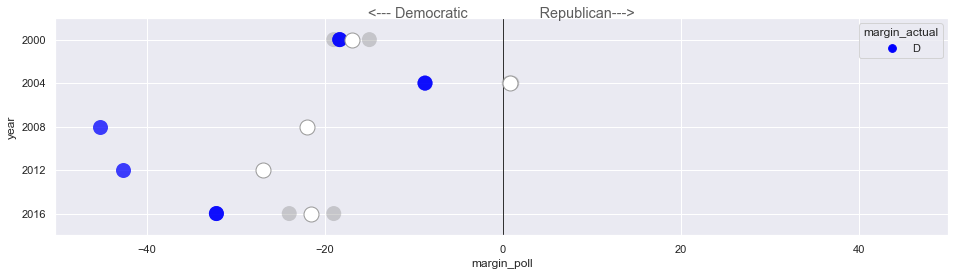

In [14]:
dotplot(polls.query("type_detail=='Pres-G' and location=='HI'"),
    y='year', x='margin_poll', result='margin_actual', 
    title='',
    subtitle='<--- Democratic                  Republican--->')

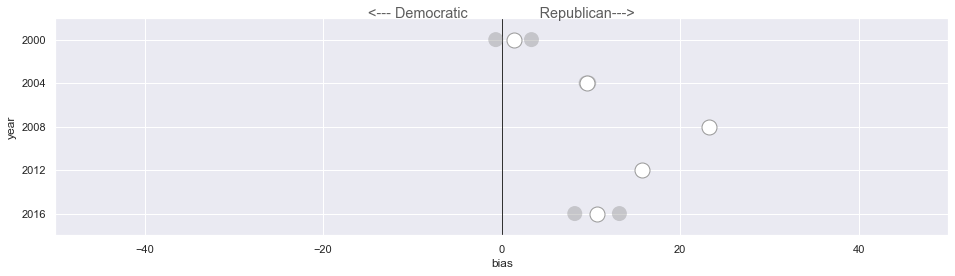

In [15]:
dotplot(polls.query("type_detail=='Pres-G' and location=='HI'"),
    y='year', x='bias', 
    title='',
    subtitle='<--- Democratic                  Republican--->')

# Part 2: Statistical Treatment

Statistical treatment can help you get more out of a dataset! Sometimes the polls miss, but have consistent biases one way or another. If we can detect these patterns, we can correct for them and get more out of the data. Here is one example of how. Let's take a look at what we know about each pollster

- Pollster Ratings: https://projects.fivethirtyeight.com/pollster-ratings/
- Methodology: https://fivethirtyeight.com/features/how-fivethirtyeight-calculates-pollster-ratings/
- Latest Update: https://fivethirtyeight.com/features/the-state-of-the-polls-2019/

In [16]:
pollster_ratings = pd.read_csv('pollster-ratings.csv').set_index('Pollster Rating ID')
pollster_ratings.head()

,Pollster,# of Polls,NCPP / AAPOR / Roper,Live Caller With Cellphones,Methodology,Banned by 538,Historical Advanced Plus-Minus,Predictive Plus-Minus,538 Grade,Mean-Reverted Bias,Races Called Correctly,Misses Outside MOE,Simple Average Error,Simple Expected Error,Simple Plus-Minus,Advanced Plus-Minus,Mean-Reverted Advanced Plus Minus,Predictive Plus-Minus,# of Polls for Bias Analysis,Bias,Mean-Reverted Bias.1,House Effect,Average Distance from Polling Average (ADPA),Herding Penalty
Pollster Rating ID,,,,,,,,,,,,,,,,,,,,,,,,
215,Monmouth University,100,yes,yes,Live,no,-1.9,-1.5,A+,D +1.3,80%,21%,5.2,6.5,-1.1,-1.9,-1.6,-1.5,70,D +1.8,D +1.3,R +0.5,5.1,0.20
304,Selzer & Co.,44,yes,yes,Live,no,-1.9,-1.4,A+,D +0.1,84%,25%,4.2,5.7,-1.3,-1.9,-1.1,-1.4,31,D +0.1,D +0.1,D +0.2,5.0,0.00
3,ABC News/Washington Post,63,yes,yes,Live,no,-1.5,-1.3,A+,D +0.6,79%,5%,2.8,4.6,-1.7,-1.5,-1.1,-1.3,58,D +0.9,D +0.6,D +1.5,3.8,0.02
87,Elway Research,21,yes,yes,Live,no,-2.5,-1.2,A/B°,D +0.5,90%,5%,3.9,6.3,-2.2,-2.5,-1.0,-1.2,20,D +1.2,D +0.5,D +3.7,4.5,0.37
94,Field Research Corp. (Field Poll),25,yes,yes,Live,no,-2.0,-1.2,A/B°,R +1.0,100%,16%,3.9,5.5,-1.5,-2.0,-0.8,-1.2,18,R +3.3,R +1.0,D +0.6,4.7,0.00


Appending adjustments based on what we know about the pollsters to the polls...

In [17]:
# Append grade
polls['grade'] = polls.pollster_rating_id.apply(lambda x: pollster_ratings.loc[x]['538 Grade'] if x in pollster_ratings.index else None)

# Append MRB and chnage it to an integer value
polls['mrb'] = polls.pollster_rating_id.apply(lambda x: pollster_ratings.loc[x]['Mean-Reverted Bias'] if x in pollster_ratings.index else None)
# reverse polarity to match above charts where D is left (-) and R is right (+)
polls['mrb'] = -pd.to_numeric(polls['mrb'].str.replace('D +', '', regex=False).str.replace('R +', '-', regex=False))

# Adjust poll, bias, and error by MRB
polls['margin_poll_adjusted'] = polls['margin_poll'] - polls['mrb']
polls['bias_adjusted'] = polls.margin_poll_adjusted - polls.margin_actual
polls['error_adjusted'] = np.abs(polls.margin_poll_adjusted - polls.margin_actual)

In [18]:
# Select all state and national polls
pres_polls_national = polls.query("type_detail=='Pres-G' and location=='US'")
pres_polls_by_state = polls.query("type_detail=='Pres-G' and location!='US'")

Let's look at some polls now! What do they look like with this insight applied? 

In [19]:
pres_polls_national.query('year==2016').sample(3)

,pollno,race,year,location,type_simple,type_detail,pollster,pollster_rating_id,polldate,samplesize,cand1_name,cand1_pct,cand2_name,cand2_pct,cand3_pct,margin_poll,electiondate,cand1_actual,cand2_actual,margin_actual,error,bias,rightcall,comment,partisan,grade,mrb,margin_poll_adjusted,bias_adjusted,error_adjusted
8092,75450,2016_Pres-G_US,2016,US,Pres-G,Pres-G,CBS News/New York Times,36,10/30/2016,927.0,Democrat,46.0,Republican,43.0,5.0,-3.0,11/8/2016,48.02,45.93,-2.09,0.91,-0.91,1.0,"by CBS News only, but FiveThirtyEight classifi...",NaN,A,-0.4,-2.6,-0.51,0.51
8146,75254,2016_Pres-G_US,2016,US,Pres-G,Pres-G,Lucid,175,10/31/2016,2617.0,Democrat,43.0,Republican,40.0,6.0,-3.0,11/8/2016,48.02,45.93,-2.09,0.91,-0.91,1.0,NaN,NaN,B/C°,-0.9,-2.1,-0.01,0.01
7771,74507,2016_Pres-G_US,2016,US,Pres-G,Pres-G,NBC News/Wall Street Journal,221,10/23/2016,724.0,Democrat,45.0,Republican,35.5,7.0,-9.5,11/8/2016,48.02,45.93,-2.09,7.41,-7.41,1.0,conducted by same team as NBC News/Wall Street...,NaN,A/B°,-0.8,-8.7,-6.61,6.61


And in the aggregate for 2016? What about for other races? Other years?

In [20]:
pres_polls_national.query('year==2016')\
    [['year', 'location', 'pollster', 'error', 'error_adjusted', 'bias', 'bias_adjusted']]\
    .groupby('year').mean()

,error,error_adjusted,bias,bias_adjusted
year,,,,
2016,2.799583,2.413472,-1.618472,-1.218472


What about at the state level?

In [21]:
pres_polls_by_state.query('year==2016')\
    [['year', 'location', 'pollster', 'error', 'error_adjusted', 'bias', 'bias_adjusted']]\
    .groupby('year').mean()

,error,error_adjusted,bias,bias_adjusted
year,,,,
2016,5.249544,4.635772,-3.535924,-2.008937


Let's see what this means for national polls by pollster

In [22]:
pres_polls_national.query("year==2016")\
    [['year', 'location', 'pollster', 'error', 'error_adjusted']]\
    .groupby('pollster').agg(['mean', 'count'])\
    .sort_values(by=('error_adjusted', 'count'), ascending=False)\
    .drop([('year', 'count'), ('error', 'count')], axis=1)

year      error error_adjusted  \
                                              mean       mean           mean   
pollster                                                                       
Lucid                                         2016   2.792857       2.150000   
Gravis Marketing                              2016   1.354000       1.894000   
Morning Consult                               2016   1.910000       1.710000   
ABC News/Washington Post                      2016   1.830000       1.530000   
Rasmussen Reports/Pulse Opinion Research      2016   1.340000       0.750000   
Ipsos                                         2016   4.185000       3.985000   
IBD/TIPP                                      2016   1.682500       1.282500   
Google Surveys                                2016   1.237500       1.287500   
USC Dornsife/LA Times                         2016   4.073333       4.373333   
People's Pundit Daily                         2016   2.956667       2.556667   
YouGov                                        2016   1.576667       1.176667   
Fox News/Beacon Research/Shaw & Co. Research  2016   1.470000       0.970000   
CBS News/New York Times                       2016   1.410000       1.010000   
SurveyMonkey                                  2016   4.410000       0.690000   
NBC News/Wall Street Journal                  2016   4.910000       4.110000   
CVOTER International                          2016   0.840000       0.840000   
GfK Group                                     2016  11.410000      11.210000   
RKM Research and Communications Inc.          2016   1.110000       1.310000   
Suffolk University                            2016   7.960000       7.460000   
Selzer & Co.                                  2016   0.910000       0.810000   
Saint Leo University                          2016   9.010000       7.010000   
CNN/Opinion Research Corp.                    2016   3.410000       3.310000   
Public Policy Polling                         2016   3.910000       3.610000   
RAND (American Life Panel)                    2016   7.010000       6.810000   
Insights West                                 2016   1.910000       2.010000   
Pew Research Center                           2016   4.410000       3.810000   
Centre College                                2016   3.860000       3.660000   
Monmouth University                           2016   3.910000       2.610000   
Angus Reid Global                             2016   1.910000       3.210000   
GQR Research (GQRR)                           2016   9.910000       7.610000   
Marist College                                2016   0.590000       0.390000   

                                                    
                                             count  
pollster                                            
Lucid                                            7  
Gravis Marketing                                 5  
Morning Consult                                  5  
ABC News/Washington Post                         4  
Rasmussen Reports/Pulse Opinion Research         4  
Ipsos                                            4  
IBD/TIPP                                         4  
Google Surveys                                   4  
USC Dornsife/LA Times                            3  
People's Pundit Daily                            3  
YouGov                                           3  
Fox News/Beacon Research/Shaw & Co. Research     3  
CBS News/New York Times                          2  
SurveyMonkey                                     2  
NBC News/Wall Street Journal                     2  
CVOTER International                             2  
GfK Group                                        1  
RKM Research and Communications Inc.             1  
Suffolk University                               1  
Selzer & Co.                                     1  
Saint Leo University                             1  
CNN/Opinion Research Corp.                       1  


Lets look at a few particular cases. Hawaii, or Washington D.C. for example.

In [23]:
pres_polls_by_state.query("year==2016 and location=='HI'")\
    [['pollster', 'grade', 'margin_actual', 'margin_poll', 'margin_poll_adjusted', 'mrb', 'bias', 'bias_adjusted']]

,pollster,grade,margin_actual,margin_poll,margin_poll_adjusted,mrb,bias,bias_adjusted
7934,SurveyMonkey,D-,-32.18,-19.0,-13.9,-5.1,13.18,18.28
8328,SurveyMonkey,D-,-32.18,-24.0,-18.9,-5.1,8.18,13.28


Uh oh, what happened here? 

Still, in the aggregate, you're better off looking at an adjusted average of the polls. Also, this is only one statsitical treatment! Remember how Hawaii polls tend to underestimate how well Democrats will do? We have adjusted for the pollster's average bias, but have not accounted for factors like that. And there are so many other things to consider! 

# Zooming Out

Let's talk about our election forecasts, which apply a lot of statistical treatments based on what we know about the nature of politics and political data in the U.S.

## The 2016 Forecast: A Case Study

- Forecast: https://projects.fivethirtyeight.com/2016-election-forecast/
- Methodology: https://fivethirtyeight.com/features/a-users-guide-to-fivethirtyeights-2016-general-election-forecast/
- Analysis: https://projects.fivethirtyeight.com/2016-election-forecast/articles/?ex_cid=2016-forecast


## Polls Stories from 2016

These help elucidate how we turn analysis, like what you just did above, into insights for our readers.

- https://fivethirtyeight.com/features/how-much-the-polls-missed-by-in-every-state/
- https://fivethirtyeight.com/features/pollsters-probably-didnt-talk-to-enough-white-voters-without-college-degrees/
- https://fivethirtyeight.com/features/what-a-difference-2-percentage-points-makes/
- https://fivethirtyeight.com/features/shy-voters-probably-arent-why-the-polls-missed-trump/
- https://fivethirtyeight.com/features/the-polls-missed-trump-we-asked-pollsters-why/
- https://fivethirtyeight.com/features/why-fivethirtyeight-gave-trump-a-better-chance-than-almost-anyone-else/
- https://fivethirtyeight.com/features/the-polls-are-all-right/
- https://fivethirtyeight.com/features/trump-is-just-a-normal-polling-error-behind-clinton/


## 2018

- https://projects.fivethirtyeight.com/2018-midterm-election-forecast/senate
- https://projects.fivethirtyeight.com/2018-midterm-election-forecast/house

## 2020 

- 2020 Primary Forecast: https://projects.fivethirtyeight.com/2020-primary-forecast/
- 2020 General Election Forecast: STAY TUNED!

## Some other folks

- [CNN](https://www.cnn.com/election/2018/forecast)
- [Daily Kos](https://elections.dailykos.com/)
- [New York Times - Real Time Polling!](https://www.nytimes.com/interactive/2018/upshot/elections-polls.html)


# Visualizing Uncertainty

- FiveThirtyEight in [2010](https://www.nytimes.com/elections/2010/forecasts/senate.html), [2014](https://fivethirtyeight.com/interactives/senate-forecast/), [2016](https://projects.fivethirtyeight.com/2016-election-forecast/), [2018](https://projects.fivethirtyeight.com/2018-midterm-election-forecast/house/)
    * I think 2010 still works in Safari...
- New York Times
    * The Spinners https://www.nytimes.com/2014/11/01/upshot/how-confirmation-bias-can-lead-to-a-spinning-of-wheels.html
    * The Needle https://www.youtube.com/watch?v=iq5rW6zYeP4
- [Huffpost's](http://elections.huffingtonpost.com/pollster) custom charts.

